In [38]:
%matplotlib inline

import os
import urllib.request
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit as curve_fit
import scipy.integrate as integrate
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
from scipy.stats import chi2 as chi2
from IPython.display import display, Math, Latex

for dirs in ('./data', './figures'):
    if not os.path.exists(dirs): os.mkdir(dirs)

### Download Data

In [39]:
today = datetime.now().strftime("%Y%m%d")
urllib.request.urlretrieve('https://covid.ourworldindata.org/data/ecdc/full_data.csv', './data/full_data_'+today+'.csv')

('./data/full_data_20200401.csv', <http.client.HTTPMessage at 0x7f6fb6176cf8>)

In [40]:
fulldata = pd.read_csv('./data/full_data_'+today+'.csv', parse_dates=True)

### Sort data

In [41]:
# Data for world (without China)
worlddata = fulldata[fulldata.location=='World']
cndata = fulldata[fulldata.location=='China']
wocndata = worlddata
wocndata.location = 'woCN'
wocndata.total_cases = worlddata.total_cases.values - cndata.total_cases.values
wocndata.new_cases = worlddata.new_cases.values - cndata.new_cases.values
wocndata.total_deaths = worlddata.total_deaths.values - cndata.total_deaths.values
wocndata.new_deaths = worlddata.new_deaths.values - cndata.new_deaths.values
fulldata = pd.concat((fulldata, wocndata))

In [42]:
#data = fulldata[fulldata.location=='woCN']
data = fulldata[fulldata.location=='Germany']
cases = data.total_cases.values
date = data.date.values
data['datetime'] = pd.to_datetime(data.date)
data['days'] = data.datetime.values - data.datetime.values[0]
days = data.days.values.astype('timedelta64[D]').astype('int')

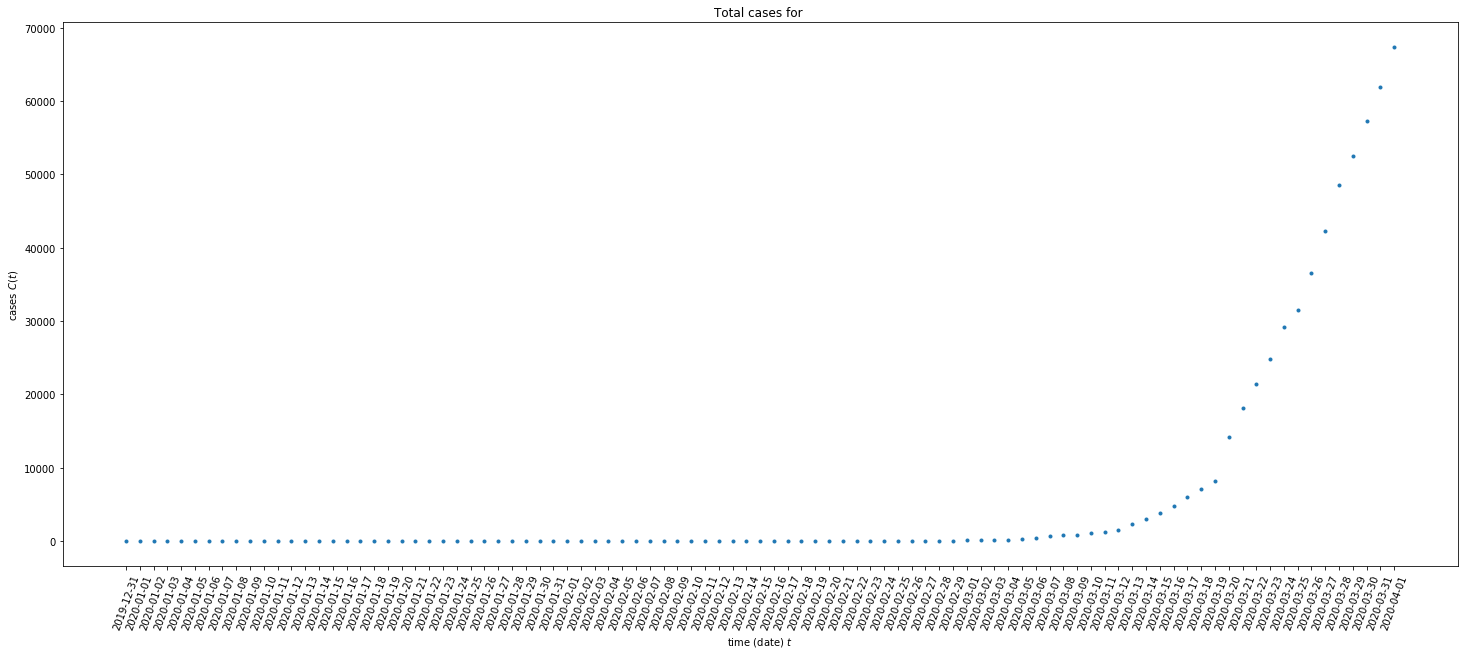

In [46]:
plt.figure(figsize=(25,10))
plt.yscale('linear')
plt.ylabel('cases $C(t)$')
plt.xlabel('time (date) $t$')
plt.title('Total cases for ')
plt.xticks(rotation=70)
plt.plot(date, cases, '.')
plt.savefig('./figures/ncov_de_total_cases.png', format='png')
plt.show()

#### Select timespan

In [ ]:
first = days[cases!=0][0]
display(Latex('First case on day $'+str(days[first])+'$.'))
tfrom, tto, future = 80, -1, 10
fulltime = np.arange(0, days[-1]+future)
display(Latex('Fitting data from days $'+str(days[tfrom])+'$ to $' + str(days[tto]) + '$.'))

## Models

#### Exponential growth

$ C(t) = a \cdot e^{b\cdot t} + d$

In [21]:
# Linear fit for checking if fitting even works
#def linear(t, a, b):
#    return a * t + b

def exponential(t, a, b, c):
    return a*np.exp(b*t) + c

popt, pcov = curve_fit(exponential, days[tfrom:tto], cases[tfrom:tto], maxfev=50000, p0=[1,1,0], bounds=([-1e+6,-1, -1000],[1e+6, +4, +1000]))
#popt, pcov = curve_fit(linear, days[tfrom:tto], cases[tfrom:tto], maxfev=50000, p0=[1,0])
display(Latex('Resulting fit-parameters:'))
for i in range(len(popt)):
        display(Math(r'p_'+str(i+1)+'='+r'{:.3f}'.format(popt[i])))

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

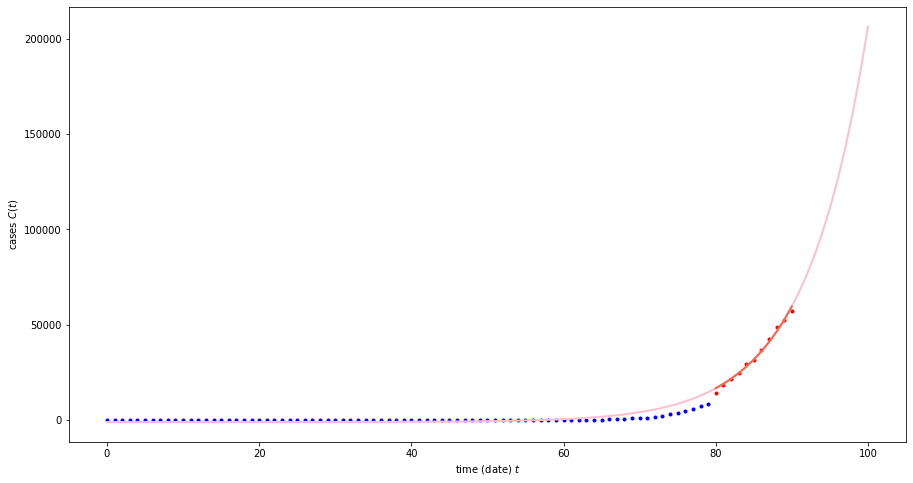

In [22]:
plt.figure(figsize=(15,8))
plt.yscale('linear')
plt.ylabel('cases $C(t)$')
plt.xlabel('time (date) $t$')
plt.plot(days[0:tfrom], cases[0:tfrom], '.', color='blue')
plt.plot(days[tto:-1], cases[tto:-1], '.', color='blue')
plt.plot(days[tfrom:tto], cases[tfrom:tto], '.', color='red')

plt.plot(fulltime, exponential(fulltime, *popt), color='pink', lw=2)
plt.plot(days[tfrom:tto], exponential(days[tfrom:tto], *popt), color='tomato', lw=2)

plt.savefig('./figures/ncov_de_total_cases_exponential.png', format='png')
plt.show()

#### Logistic growth

In [27]:
def logistic(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

popt, pcov = curve_fit(logistic, days[tfrom:tto], cases[tfrom:tto], maxfev=999999, p0=[2,100,20000])
display(Latex('Resulting fit-parameters:'))
for i in range(len(popt)):
        display(Math(r'p_'+str(i+1)+'='+r'{:.3f}'.format(popt[i])))

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

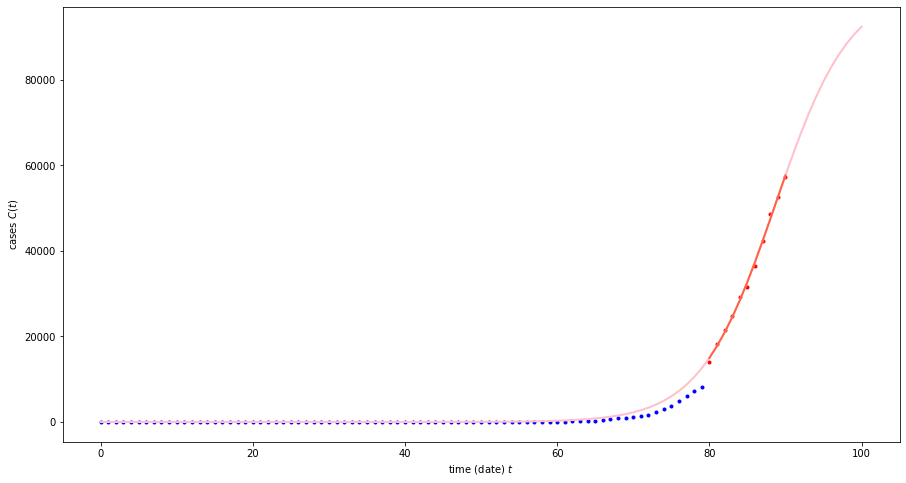

In [28]:
plt.figure(figsize=(15,8))
plt.yscale('linear')
plt.ylabel('cases $C(t)$')
plt.xlabel('time (date) $t$')
plt.plot(days[0:tfrom], cases[0:tfrom], '.', color='blue')
plt.plot(days[tto:-1], cases[tto:-1], '.', color='blue')
plt.plot(days[tfrom:tto], cases[tfrom:tto], '.', color='red')

plt.plot(fulltime, logistic(fulltime, *popt), color='pink', lw=2)
plt.plot(days[tfrom:tto], logistic(days[tfrom:tto], *popt), color='tomato', lw=2)

plt.savefig('./figures/ncov_de_total_cases_logistic.png', format='png')
plt.show()

#### $SIR$ model

In [34]:
def SIR_model(pop,t, beta, gamma):
    
    S, I, R = pop # S = Anteil der Personen, die angesteckt werden können. I = Infizierte, R = geheilte und verstorbene. 

    dS_dt = - a * S * I # a transmission coefficient
    dI_dt = a * S * I - b * I # b = 1/T, T average time of infection  
    dR_dt = b * I

    return [dS_dt, dI_dt, dR_dt]

In [68]:
S0 = 0.9990
I0 = 0.0001
R0 = 0.0001
a = 0.35
b = 0.1

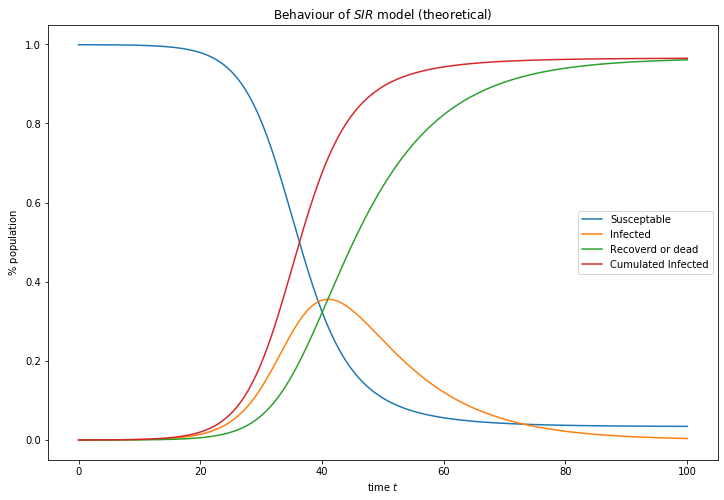

In [80]:
# time steps
t = np.linspace(0, 100, 10000)

# result
solution = integrate.odeint(SIR_model, [S0,I0,R0], t, args=(a,b))
S, I, R = np.array(solution).T
C = I + R

#plot
plt.figure(figsize=[12, 8])
plt.plot(t, S, label="Susceptable")
plt.plot(t, I, label="Infected")
plt.plot(t, R, label="Recoverd or dead")
plt.plot(t, C, label="Cumulated Infected")
plt.legend()
plt.xlabel("time $t$")
plt.ylabel("$\%$ population")
plt.title("Behaviour of $SIR$ model (theoretical)")
plt.savefig('./figures/ncov_de_sir-theory.png', format='png')
plt.show()